# Тестирование кастомного минимизатора градиентного спуска
Время работы: 6:25

In [1]:
import numpy as np
from skimage import color, data, restoration, img_as_float, io
from scipy.signal import convolve2d as conv2

from skimage.restoration import richardson_lucy
from skimage.measure import compare_psnr
from functools import partial
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
from tqdm import tqdm_notebook

from util import *
from richardson_lucy import *

In [2]:
def fun(x):
    return np.sum((x - np.array([1, 2]))**2)

In [3]:
x0 = np.array([-1, -1])
xx = np.array([1, 2])

In [4]:
fun(xx), fun(x0)

(0, 13)

In [5]:
def fun2(x):
    return (x[0] - 5)**2 + 2 * (x[1] - 10)**2

In [6]:
minimize_grad(fun2, np.array([0, 0]), alpha=1, disp=True, maxiter=100)

[0 0] 225 [ -80. -320.]
[0 0] [ 2.57575989 10.30303955]
[ 2.57575989 10.30303955] 6.060606102983002 [-38.7878418    9.69726562]
[ 2.57575989 10.30303955] [4.86535287 9.73062329]
[4.86535287 9.73062329] 0.16325751030069563 [-2.15435401 -8.62005472]
[4.86535287 9.73062329] [ 4.93471455 10.00815496]
[ 4.93471455 10.00815496] 0.004395230290899059 [-1.04456715  0.26095869]
[ 4.93471455 10.00815496] [4.9964297  9.99273699]
[4.9964297  9.99273699] 0.00011825299450174122 [-0.05712477 -0.23241633]
[4.9964297  9.99273699] [ 4.99827064 10.00022697]
[ 4.99827064 10.00022697] 3.113706093819315e-06 [-0.02766981  0.00726301]
[ 4.99827064 10.00022697] [5.         9.99977303]
[5.         9.99977303] 1.4207965172205804e-07 [ 0.         -0.00726301]
[5.         9.99977303] [ 5. 10.]
[ 5. 10.] 2.5757480188969746e-08 [0. 0.]
[ 5. 10.] [ 5. 10.]


 nfev: 193
  nit: 8
    x: array([ 5., 10.])

In [7]:
astro = color.rgb2gray(data.astronaut())
liftingbody = img_as_float(io.imread('liftingbody.png'))
iterations = 30

[15, 4, 20, 20]


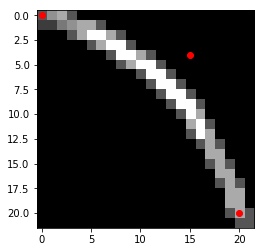

In [8]:
sz = 21
deg = 5
points_real = [(deg - 1) * sz // deg - 1, sz // deg, sz - 1, sz - 1]
print(points_real)
#points_real = [sz, 0, sz, sz]
psf_bezier = bezier_psf2(points_real)
plt.imshow(psf_bezier, 'gray')
plt.plot(0, 0, 'ro')
plt.plot(points_real[0], points_real[1], 'ro')
plt.plot(points_real[2], points_real[3], 'ro')
#plt.savefig("pic/curved-psf.png")
plt.show()

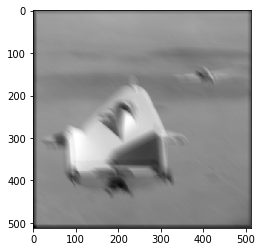

In [9]:
lifting_bezier_blurred = convolve2d(liftingbody, psf_bezier, 'same')
plt.imshow(lifting_bezier_blurred, 'gray')
plt.show()

In [10]:
s_n, S_find = find_noise(lifting_bezier_blurred)
s_n

7.267261165382173e-05

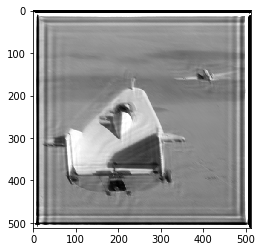

In [11]:
deconv = richardson_lucy_matlab(
    lifting_bezier_blurred,
    psf_bezier,
    iterations=iterations,
    clip=True,
    dampar=0.004,
    useFFT=True)
plt.imshow(deconv['image'], 'gray')
plt.show()

In [12]:
N, M = lifting_bezier_blurred.shape
# ( ifft2 (100* log (1+ abs ( fft2 ( I ) ) ) ) ) ;
K = np.fft.ifftn(100 * np.log(1 + np.abs(np.fft.fftn(lifting_bezier_blurred))))
K_shift = np.fft.fftshift(K)

In [13]:
c, r = np.unravel_index(np.argmin(K_shift, axis=None), K_shift.shape)
#nn = np.argmin(np.real(K_shift))
n, m, = K_shift.shape
x0_2 = np.array([r - n // 2, c - m // 2])
x0_1 = x0_2 / 3 + np.array([2, -2])
x0 = np.concatenate((x0_1, x0_2))
print(x0_1, x0_2)

[8.66666667 5.        ] [20 21]


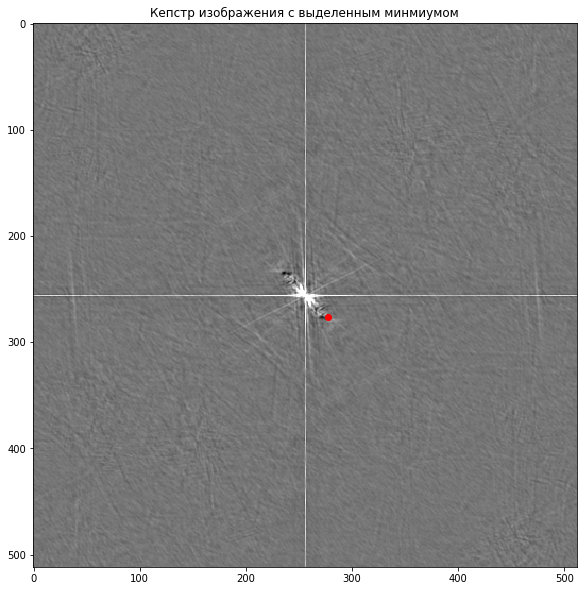

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(np.clip(np.real(K_shift), -1, 1),
           'gray')  #, vmin=noisy.min(), vmax=noisy.max())
plt.plot(n // 2 + x0_2[1], m // 2 + x0_2[0], 'ro')
plt.title('Кепстр изображения с выделенным минмиумом')
#plt.savefig('pic/kepstr.png')
plt.show()

In [15]:
res_my_grad = minimize_grad(partial(funcToMinimizeCurved2, xy2=x0_2, I_blurred=lifting_bezier_blurred,
                                    iterations=iterations, eps=1e-5, dampar=10*s_n, useFFT=True),
                            x0=x0_1, disp=True, alpha=100)
print(res_my_grad)
#res_my_

[8.66666667 5.        ] 4.2911171280336895e-05 [-0.00029339  0.00027725]
[8.66666667 5.        ] [8.66666667 5.        ]
 nfev: 18
  nit: 1
    x: array([8.66666667, 5.        ])


In [16]:
res_my_grad2 = minimize_grad(partial(funcToMinimizeCurved2, xy2=x0_2, I_blurred=lifting_bezier_blurred,
                                     iterations=iterations, eps=1e-5, dampar=10*s_n, useFFT=True),
                             x0=x0_1, disp=True, alpha=1000)
print(res_my_grad)
#res_my_

[8.66666667 5.        ] 4.2911171280336895e-05 [-0.00029339  0.00027725]
[8.66666667 5.        ] [9.8035662  3.92566867]
[9.8035662  3.92566867] 2.1160017613813898e-05 [-3.73834330e-05  1.58799055e-05]
[9.8035662  3.92566867] [9.8035662  3.92566867]
 nfev: 18
  nit: 1
    x: array([8.66666667, 5.        ])


In [17]:
res_my_grad2 = OptimizeResult(x=np.concatenate((res_my_grad['x'], x0_2)))

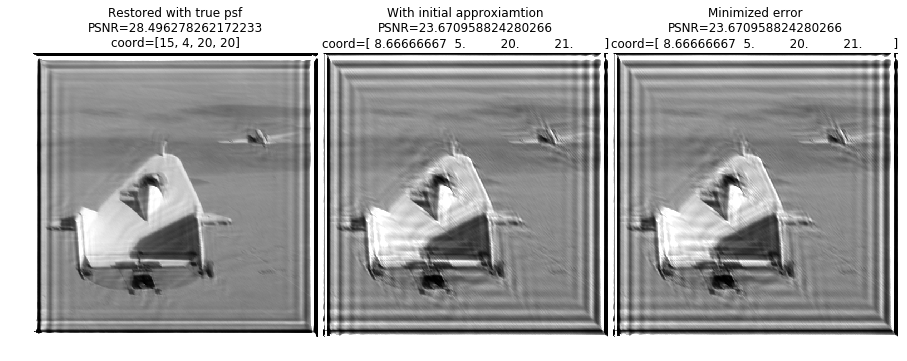

In [18]:
deconv_orig = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_bezier_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

points_found = res_my_grad2['x']
psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_bezier_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig, points_real), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init, x0),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found, res_my_grad2['x'])])